In [1]:
%matplotlib notebook
#import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import os, os.path
import glob
import h5py
import pickle
import numpy as np
import pynbody
from numpy.polynomial import Polynomial
from mpl_toolkits import mplot3d
from scipy import ndimage, signal, interpolate
from astropy.coordinates import SkyCoord,Galactic,ICRS,Galactocentric
import astropy.coordinates as coord
from galpy.potential import NFWPotential,DoubleExponentialDiskPotential,MN3ExponentialDiskPotential,HernquistPotential,ChandrasekharDynamicalFrictionForce
from galpy.orbit import Orbit
from galpy.potential import MWPotential2014,MiyamotoNagaiPotential
from galpy.util import bovy_conversion, save_pickles, bovy_coords, bovy_plot
#import seaborn as sns
from matplotlib import animation
from scipy.stats import gaussian_kde
import astropy.units as u
from scipy.interpolate import interpn
from galpy import potential

#from matplotlib import cm, pyplot
from galpy.potential import evaluatezforces

coord.galactocentric_frame_defaults.set('v4.0') 

<ScienceState galactocentric_frame_defaults: {'galcen_coord': <ICRS Coordinate: (ra, dec) in deg...>

In [37]:
ro=8.
vo=220.

def galcencyl_to_lbd(R,phi,Z,degree=True):
        xyz=bovy_coords.galcencyl_to_XYZ(R,phi,Z)
        l=[]
        b=[]
        d=[]
        for ii in range(len(xyz)):
            lbd=bovy_coords.XYZ_to_lbd(xyz[ii][0],xyz[ii][1],xyz[ii][2],degree=degree)
            l.append(lbd[0])
            b.append(lbd[1])
            d.append(lbd[2])
            
        return (l,b,d)
    
def read_snapshot(fname='test.hdf5',read_axes='Coordinates',ptype=1):
    data = h5py.File(fname, 'r')
    group = data['PartType{}'.format(int(ptype))]
    
    try:
        dd=group[read_axes][()]
        try:
            if np.size(dd,1) ==3:
                return (dd[:,0],dd[:,1],dd[:,2])
    
        except IndexError:
            return (dd)
    
    except KeyError:
        print ("Allowed axes names %s"%group.keys())
        
        
def extract_data_of_ptype(folder="",ptype=1,nfiles=100,shift_file_ind=0,shift_ID=0,pot_acc=True):
    #currently only supports: coordinates, velocities, mass, ID, acceleration,potential
    ids=[];m=[];x=[];y=[];z=[];vx=[];vy=[];vz=[];pot=[];ax=[];ay=[];az=[];tt=[];

    time_series = [0.01*(i+shift_file_ind) for i in range(nfiles-shift_file_ind)]

    #print (time_series)

    for nn in range(shift_file_ind,nfiles):
                
        tt.append(time_series[nn-shift_file_ind])
        _x,_y,_z=read_snapshot(fname=folder + 'snapshot_{:03d}.hdf5'.format(nn),ptype=ptype)
        _vx,_vy,_vz=read_snapshot(fname=folder + 'snapshot_{:03d}.hdf5'.format(nn),ptype=ptype,read_axes="Velocities")
        _ids=read_snapshot(fname=folder + 'snapshot_{:03d}.hdf5'.format(nn),ptype=ptype,read_axes="ParticleIDs")
        _ms=read_snapshot(fname=folder + 'snapshot_{:03d}.hdf5'.format(nn),ptype=ptype,read_axes="Masses")
        
        _x = _x[_ids >=shift_ID]
        _y = _y[_ids >=shift_ID]
        _z = _z[_ids >=shift_ID]
        _vx = _vx[_ids >=shift_ID]
        _vy = _vy[_ids >=shift_ID]
        _vz = _vz[_ids >=shift_ID]
        _ms = _ms[_ids >=shift_ID]
                      
        if pot_acc:
            _pot=read_snapshot(fname=folder + 'snapshot_{:03d}.hdf5'.format(nn),ptype=ptype,read_axes="Potential")
            _pot = _pot[_ids >=shift_ID]
            _ax,_ay,_az=read_snapshot(fname=folder + 'snapshot_{:03d}.hdf5'.format(nn),ptype=ptype,read_axes="Acceleration")
            _ax = _ax[_ids >=shift_ID]
            _ay = _ay[_ids >=shift_ID]
            _az = _az[_ids >=shift_ID]
        
        _ids=_ids[_ids >=shift_ID]
        
                    
        id_sort = _ids.argsort()

        _ids=_ids[id_sort]
        _x=_x[id_sort]
        _y=_y[id_sort]
        _z=_z[id_sort]
        _vx=_vx[id_sort]
        _vy=_vy[id_sort]
        _vz=_vz[id_sort]
        _ms=_ms[id_sort]
        
        ids.append(_ids)
        x.append(_x)
        y.append(_y)
        z.append(_z)
        vx.append(_vx)
        vy.append(_vy)
        vz.append(_vz)
        m.append(_ms) 
        
        if pot_acc:
            _pot = _pot[id_sort]
            _ax = _ax[id_sort]
            _ay = _ay[id_sort]
            _az = _az[id_sort]
            pot.append(_pot)
            ax.append(_ax)
            ay.append(_ay)
            az.append(_az)
    
    if pot_acc:
        return (tt,ids,x,y,z,vx,vy,vz,m,pot,ax,ay,az)
            
    return (tt,ids,x,y,z,vx,vy,vz,m)

        

def make_IC(xv_d,yv_d,zv_d,vx_d,vy_d,vz_d,mv_d,fn='test',ptype=1):
    '''
    This is an example subroutine provided to demonstrate how to make HDF5-format
    ICs for GIZMO. The specific example here is arbitrary, but can be generalized
    to whatever IC you need
    
    Modified by Nil: This now takes (x,y,z,vx,vy,vz,m) of a prticular particle type
    and then generates a Gizmo compatible IC. This is useful incase we want to extract a certain subset 
    of particles from another snapshot/IC and use that as an IC for another run.
    
    As of now, it only handles one particle type at a time.
    
     
    
    '''

    fname=fn; # output filename 

    # now we get ready to actually write this out
    #  first - open the hdf5 ics file, with the desired filename
    file = h5py.File(fname,'w') 

    # set particle number of each type into the 'npart' vector
    #  NOTE: this MUST MATCH the actual particle numbers assigned to each type, i.e.
    #   npart = np.array([number_of_PartType0_particles,number_of_PartType1_particles,number_of_PartType2_particles,
    #                     number_of_PartType3_particles,number_of_PartType4_particles,number_of_PartType5_particles])
    #   or else the code simply cannot read the IC file correctly!
    Ngrains=len(xv_d)
    npart = np.array([0,0,0,0,0,0]) # we have gas and particles we will set for type 3 here, zero for all others
    npart[ptype]+=Ngrains
    # now we make the Header - the formatting here is peculiar, for historical (GADGET-compatibility) reasons
    h = file.create_group("Header");
    # here we set all the basic numbers that go into the header
    # (most of these will be written over anyways if it's an IC file; the only thing we actually *need* to be 'correct' is "npart")
    h.attrs['NumPart_ThisFile'] = npart; # npart set as above - this in general should be the same as NumPart_Total, it only differs 
                                         #  if we make a multi-part IC file. with this simple script, we aren't equipped to do that.
    h.attrs['NumPart_Total'] = npart; # npart set as above
    h.attrs['NumPart_Total_HighWord'] = 0*npart; # this will be set automatically in-code (for GIZMO, at least)
    h.attrs['MassTable'] = np.zeros(6); # these can be set if all particles will have constant masses for the entire run. however since 
                                        # we set masses explicitly by-particle this should be zero. that is more flexible anyways, as it 
                                        # allows for physics which can change particle masses 
    ## all of the parameters below will be overwritten by whatever is set in the run-time parameterfile if
    ##   this file is read in as an IC file, so their values are irrelevant. they are only important if you treat this as a snapshot
    ##   for restarting. Which you shouldn't - it requires many more fields be set. But we still need to set some values for the code to read
    h.attrs['Time'] = 0.0;  # initial time
    h.attrs['Redshift'] = 0.0; # initial redshift
    h.attrs['BoxSize'] = 1.0; # box size
    h.attrs['NumFilesPerSnapshot'] = 1; # number of files for multi-part snapshots
    h.attrs['Omega0'] = 1.0; # z=0 Omega_matter
    h.attrs['OmegaLambda'] = 0.0; # z=0 Omega_Lambda
    h.attrs['HubbleParam'] = 1.0; # z=0 hubble parameter (small 'h'=H/100 km/s/Mpc)
    h.attrs['Flag_Sfr'] = 0; # flag indicating whether star formation is on or off
    h.attrs['Flag_Cooling'] = 0; # flag indicating whether cooling is on or off
    h.attrs['Flag_StellarAge'] = 0; # flag indicating whether stellar ages are to be saved
    h.attrs['Flag_Metals'] = 0; # flag indicating whether metallicity are to be saved
    h.attrs['Flag_Feedback'] = 0; # flag indicating whether some parts of springel-hernquist model are active
    h.attrs['Flag_DoublePrecision'] = 0; # flag indicating whether ICs are in single/double precision
    h.attrs['Flag_IC_Info'] = 0; # flag indicating extra options for ICs
    ## ok, that ends the block of 'useless' parameters
    
    # Now, the actual data!
    #   These blocks should all be written in the order of their particle type (0,1,2,3,4,5)
    #   If there are no particles of a given type, nothing is needed (no block at all)
    #   PartType0 is 'special' as gas. All other PartTypes take the same, more limited set of information in their ICs
    
    # now assign the collisionless particles to PartType1. note that this block looks exactly like 
    #   what we had above for the gas. EXCEPT there are no "InternalEnergy" or "MagneticField" fields (for 
    #   obvious reasons). 
    
    # use index as id
    id_d=np.arange(0,Ngrains,1)
    
    
    p = file.create_group("PartType{}".format(ptype))
    q=np.zeros((Ngrains,3)); q[:,0]=xv_d; q[:,1]=yv_d; q[:,2]=zv_d;
    p.create_dataset("Coordinates",data=q)
    q=np.zeros((Ngrains,3)); q[:,0]=vx_d; q[:,1]=vy_d; q[:,2]=vz_d;
    p.create_dataset("Velocities",data=q)
    p.create_dataset("ParticleIDs",data=id_d)
    p.create_dataset("Masses",data=mv_d)

    # no PartType4 for this IC
    # no PartType5 for this IC

    # close the HDF5 file, which saves these outputs
    file.close()
    # all done!
    
def make_gizmo_IC(fname_list,offset_list=[],fout_name="test_out.hdf5"):
    
    '''
    This takes in a list of ICs generated by GalIC or something and combined them into one 
    IC in a format compatible with Gizmo
    
    offset_list: a list with each element an array or list of phase space offset for each file
    For no offset like for the main halo, simply put [0. 0. 0. 0. 0. 0.] 
    phase space coordinate must be in the form [x(kpc),y(kpc),z(kpc),vx(km/s),vy(km/s),vz(km/s)]
    order of offset elements must follow that in the fname list
    
        
    '''
    #set offsets to 0 in case no offset provided
    if len(offset_list) == 0:
        _ofs=np.zeros(6)
        offset_list = [_ofs]*len(fname_list)
    
    
    npart=np.array([0,0,0,0,0,0])
    pos=[None]*6
    vel=[None]*6
    mass=[None]*6
    ids=[None]*6
        
    for ii in range(6):
        x=[]
        y=[]
        z=[]
        vx=[]
        vy=[]
        vz=[]
        m=[]
        
        print (ii)
        for ff in range(len(fname_list)):
            data = h5py.File(fname_list[ff], 'r')
            if "PartType{}".format(ii) in data.keys():
                _x,_y,_z = read_snapshot(fname=fname_list[ff],read_axes='Coordinates',ptype=ii)
                _vx,_vy,_vz = read_snapshot(fname=fname_list[ff],read_axes='Velocities',ptype=ii)
                _m = read_snapshot(fname=fname_list[ff],read_axes='Masses',ptype=ii)
                              
                #add offsets
                _x+=offset_list[ff][0];_y+=offset_list[ff][1];_z+=offset_list[ff][2];
                _vx+=offset_list[ff][3];_vy+=offset_list[ff][4];_vz+=offset_list[ff][5];
                                 
                x.append(_x);y.append(_y);z.append(_z);
                vx.append(_vx);vy.append(_vy);vz.append(_vz);
                m.append(_m)
                                
                                     
            else:
                print ("No PartType %i found in %s"%(ii,fname_list[ff]))
                pass
        
        x=np.array([st for sublist in x for st in sublist]);y=np.array([st for sublist in y for st in sublist]);
        z=np.array([st for sublist in z for st in sublist]);vx=np.array([st for sublist in vx for st in sublist]);
        vy=np.array([st for sublist in vy for st in sublist]);vz=np.array([st for sublist in vz for st in sublist]);
        m=np.array([st for sublist in m for st in sublist]);
        
        print (len(x))
        ids[ii]=np.arange(0,len(m),1)
        npart[ii]+=len(x)
        pos[ii]=np.c_[x,y,z]
        vel[ii]=np.c_[vx,vy,vz]
        mass[ii]=m
        
    
    print (npart)
    # now we get ready to actually write this out
    #  first - open the hdf5 ics file, with the desired filename
    
    file = h5py.File(fout_name,'w') 

    h = file.create_group("Header");
    # here we set all the basic numbers that go into the header
    # (most of these will be written over anyways if it's an IC file; the only thing we actually *need* to be 'correct' is "npart")
    h.attrs['NumPart_ThisFile'] = npart; # npart set as above - this in general should be the same as NumPart_Total, it only differs 
                                         #  if we make a multi-part IC file. with this simple script, we aren't equipped to do that.
    h.attrs['NumPart_Total'] = npart; # npart set as above
    h.attrs['NumPart_Total_HighWord'] = 0*npart; # this will be set automatically in-code (for GIZMO, at least)
    h.attrs['MassTable'] = np.zeros(6); # these can be set if all particles will have constant masses for the entire run. however since 
                                        # we set masses explicitly by-particle this should be zero. that is more flexible anyways, as it 
                                        # allows for physics which can change particle masses 
    ## all of the parameters below will be overwritten by whatever is set in the run-time parameterfile if
    ##   this file is read in as an IC file, so their values are irrelevant. they are only important if you treat this as a snapshot
    ##   for restarting. Which you shouldn't - it requires many more fields be set. But we still need to set some values for the code to read
    h.attrs['Time'] = 0.0;  # initial time
    h.attrs['Redshift'] = 0.0; # initial redshift
    h.attrs['BoxSize'] = 1.0; # box size
    h.attrs['NumFilesPerSnapshot'] = 1; # number of files for multi-part snapshots
    h.attrs['Omega0'] = 1.0; # z=0 Omega_matter
    h.attrs['OmegaLambda'] = 0.0; # z=0 Omega_Lambda
    h.attrs['HubbleParam'] = 1.0; # z=0 hubble parameter (small 'h'=H/100 km/s/Mpc)
    h.attrs['Flag_Sfr'] = 0; # flag indicating whether star formation is on or off
    h.attrs['Flag_Cooling'] = 0; # flag indicating whether cooling is on or off
    h.attrs['Flag_StellarAge'] = 0; # flag indicating whether stellar ages are to be saved
    h.attrs['Flag_Metals'] = 0; # flag indicating whether metallicity are to be saved
    h.attrs['Flag_Feedback'] = 0; # flag indicating whether some parts of springel-hernquist model are active
    h.attrs['Flag_DoublePrecision'] = 0; # flag indicating whether ICs are in single/double precision
    h.attrs['Flag_IC_Info'] = 0; # flag indicating extra options for ICs
    ## ok, that ends the block of 'useless' parameters
    
    # Now, the actual data!
    #   These blocks should all be written in the order of their particle type (0,1,2,3,4,5)
    #   If there are no particles of a given type, nothing is needed (no block at all)
    #   PartType0 is 'special' as gas. All other PartTypes take the same, more limited set of information in their ICs
    
    # now assign the collisionless particles to PartType1. note that this block looks exactly like 
    #   what we had above for the gas. EXCEPT there are no "InternalEnergy" or "MagneticField" fields (for 
    #   obvious reasons). 
    
    for jj in range(6):
        if npart[jj] != 0 :
                        
                p = file.create_group("PartType{}".format(jj))
                p.create_dataset("Coordinates",data=pos[jj])
                p.create_dataset("Velocities",data=vel[jj])
                p.create_dataset("ParticleIDs",data=ids[jj])
                p.create_dataset("Masses",data=mass[jj])
            
                   
    file.close()
       
        
    return None

def Gizmo_to_pynbody(fn="test.hdf5",ptypes=[1,2,3,4,5],eps_list=[0.1,1.0,1.0,1.0,1.0]):
    '''
    We are going to merge all ptypes to dm
    '''
    x=[]
    y=[]
    z=[]
    vx=[]
    vy=[]
    vz=[]
    m=[] 
    eps=[]
    for pt in ptypes:
        _x,_y,_z = read_snapshot(fname=fn,read_axes='Coordinates',ptype=pt)
        _vx,_vy,_vz = read_snapshot(fname=fn,read_axes='Velocities',ptype=pt)
        _m=read_snapshot(fname=fn,read_axes='Masses',ptype=pt)
        
        _x = _x.tolist()
        _y = _y.tolist()
        _z = _z.tolist()
        _vx = _vx.tolist()
        _vy = _vy.tolist()
        _vz = _vz.tolist()
        _m = _m.tolist()
        
        x.append(_x)
        y.append(_y)
        z.append(_z)
        vx.append(_vx)
        vy.append(_vy)
        vz.append(_vz)
        m.append(_m)
        
        eps.append(np.ones(len(_x),dtype=np.float64).tolist())
        
    x = np.array([item for sublist in x for item in sublist])
    y = np.array([item for sublist in y for item in sublist])
    z = np.array([item for sublist in z for item in sublist])
    vx = np.array([item for sublist in vx for item in sublist])
    vy = np.array([item for sublist in vy for item in sublist])
    vz = np.array([item for sublist in vz for item in sublist])
    m = np.array([item for sublist in m for item in sublist])
    eps = np.array([item for sublist in eps for item in sublist])

    pos1= np.c_[(x,y,z)]
    vel1= np.c_[(vx,vy,vz)]
    
    f = pynbody.snapshot.new(dm=len(m))
    f['pos'] =pynbody.array.SimArray(pos1,"kpc")
    f['vel'] =pynbody.array.SimArray(vel1,'km s**-1')
    f['mass'] =pynbody.array.SimArray(m*1e10,'Msol')
    f['eps'] = pynbody.array.SimArray(eps,'kpc')
    f.physical_units()
    
    return (f)

from scipy.stats import gaussian_kde
def compute_surface_density(x,y,bins=[30,30],bw="scott",method="Gaussian"):
    
    if method == "hist": #may result in ridges in the density
        data , x_e, y_e = np.histogram2d( x, y, bins = bins, density = True )
        dens = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

        #To be sure to plot all data
        dens[np.where(np.isnan(dens))] = 0.0
        idx = dens.argsort()
        x, y, dens = x[idx], y[idx], dens[idx]
        
    elif method == "Gaussian": #slower
          
        xy = np.vstack((x,y))
        dens = gaussian_kde(xy,bw_method=bw)(xy)
        X = np.c_[x,y]
        idx = dens.argsort()
        x, y, dens = X[:,0][idx], X[:,1][idx], dens[idx]
    
    #print (dens.argmax())
    x_core = x[dens.argmax()]
    y_core = y[dens.argmax()]
    return (x_core,y_core,dens,x,y)

def Plot_Surface_Density(ax,x,y,label=""):
    from scipy.stats import gaussian_kde
    # Calculate the point density
    xy = np.vstack((x,y))
    z = gaussian_kde(xy)(xy)
    X = np.c_[x,y]
    idx = z.argsort()
    
    x, y, z = X[:,0][idx], X[:,1][idx], z[idx]
    
    ax.imshow(x,y, c=z, s=10, edgecolor='',alpha=0.5)
    ax.vlines(x[z.argmax()],-100,100,color='k',lw=1,ls="--")
    ax.hlines(y[z.argmax()],-100,100,color='k',lw=1,ls="--")
    ax.scatter(x[z.argmax()],y[z.argmax()],s=10,marker='o',c='b',label=label)
    ax.legend(loc="upper right")
    
    return None

                
  

First, we will take the GD-1 cluster, place it at the phase space coordinates consistent with $\phi_{1} = -40^{\circ}$, then we will flip its velocity and integrate in a live halo. We will then compare the evolution by integrating the same cluster in an analogous analytic MW halo potential 

In [3]:
o= Orbit.from_name("GD1")

c1 = coord.ICRS(ra=o.ra()*u.degree, dec=o.dec()*u.degree,
                distance=o.dist()*u.kpc,
                pm_ra_cosdec=o.pmra()*u.mas/u.yr,
                pm_dec=o.pmdec()*u.mas/u.yr,
                radial_velocity=o.vlos()*u.km/u.s)

gc1 = c1.transform_to(coord.Galactocentric)

print(gc1.x,gc1.y,gc1.z,gc1.v_x,gc1.v_y,gc1.v_z)

-12.726089322382306 kpc -0.6519411336112344 kpc 5.975650034386612 kpc -73.32820069269474 km / s -210.86651691603197 km / s -100.05304504390998 km / s


Make the IC files: 1. with the live halo 2. with only the cluster (for the analytic potential)

In [ ]:
dirMW = "../GALIC0/Model-MW_GB_onlyhalo_Mres1e4Msun/"
fn1 = "ics/GD1_model_N16W2R20_eps2pcinit_noOffset.hdf5"

fn = dirMW + "snap_010.hdf5"

fn_list=[fn,fn1]
         
#fn_list = [fn1]

offset = np.array([0.,0.,0.,0.,0.,0.])
#velocity flipped
gd1_offset = np.array([gc1.x.value,gc1.y.value,gc1.z.value,-1*gc1.v_x.value,-1*gc1.v_y.value,-1*gc1.v_z.value]) 

off_list=[offset,gd1_offset]
#off_list= [gd1_offset]

#print (off_list)

make_gizmo_IC(fname_list=fn_list,offset_list=off_list,fout_name="ics/MW_GB_Mres1e4Msun_GD-1_currentPos_velflipped.hdf5")


## Visualize! 

Plot surface density \
Find core location based on highest density point \
Compute the mean velocity of the stars within r radius around the highest density point.

In [ ]:
dir1 = "ics/MW_GB_Mres1e4Msun_GD-1_currentPos_velflipped_Disk/"
dir2 = "ics/MW_GB_Mres1e4Msun_GD-1_currentPos_velflipped_Disk/"

mm = 40
mn= mm 
#tt4a,id4a,x4a,y4a,z4a,vx4a,vy4a,vz4a,m4a= extract_data_of_ptype(folder=dir1,ptype=4,nfiles=mm,shift_file_ind=400,shift_ID=0,pot_acc=False)

tt4,id4,x4,y4,z4,vx4,vy4,vz4,m4 = extract_data_of_ptype(folder=dir1,ptype=4,nfiles=mn+1,shift_file_ind=mn,shift_ID=0,pot_acc=False)

xcore,ycore,densxy,X_xy,Y_xy= compute_surface_density(x4[0],y4[0])
_,zcore,densxz,X_xz,Z_xz = compute_surface_density(x4[0],z4[0])

theta = np.linspace(0,2*np.pi,1000)
r = 0.2
f, axes = plt.subplots(nrows = 1, ncols = 2,figsize=(8,4))
f.suptitle("{:.2f} Gyr".format(0.1*mm))

sc = axes[0].scatter(X_xy,Y_xy,c=densxy,s=1)
axes[0].scatter(X_xy,Y_xy,c=densxy,s=1)
axes[0].plot(xcore + r*np.cos(theta),ycore+r*np.sin(theta),color='r')
axes[0].scatter(X_xy[densxy.argmax()],Y_xy[densxy.argmax()],s=10,marker='o',c='b',label=r"")
#axes[0].text(-15,-105,"core = ({:.2f},{:.2f})".format(xcore,ycore))
axes[0].legend(loc="upper right")
axes[0].set_xlabel('X (kpc)')
axes[0].set_ylabel('Y (kpc)')

axes[1].plot(xcore + r*np.cos(theta),zcore+r*np.sin(theta),color='r')
axes[1].scatter(X_xz,Z_xz,c=densxz,s=1)
axes[1].scatter(X_xz[densxz.argmax()],Z_xz[densxz.argmax()],s=10,marker='o',c='b',label=r"")
#axes[1].text(-15,-105,"core = ({:.2f},{:.2f})".format(xcore_star_cdm,zcore_star_cdm))
axes[1].legend(loc="upper right")
axes[1].set_xlabel('X (kpc)')
axes[1].set_ylabel('Z (kpc)')
cbar_ax = f.add_axes([0.93, 0.15, 0.03, 0.7])

f.colorbar(sc,cax=cbar_ax)
#plt.tight_layout()
#plt.savefig('GD1_with_analyticDisk_Mres1e4Msun_{:.2f}.pdf'.format(0.1*mm), bbox_inches = "tight")
plt.show()

#condition for choosing all points within r 
cond = np.sqrt((x4[0] - xcore)**2 + (y4[0] - ycore)**2 + (z4[0] - zcore)**2) < r

_x4 = x4[0][cond]
_y4 = y4[0][cond]
_z4 = z4[0][cond]
_vx4 = vx4[0][cond]
_vy4 = vy4[0][cond]
_vz4 = vz4[0][cond]

vx_mean = np.mean(_vx4)
vy_mean = np.mean(_vy4)
vz_mean = np.mean(_vz4)

print (xcore,ycore,zcore)
print (vx_mean,vy_mean,vz_mean)


Flip the velocity of the particles of the live halo

In [ ]:
#try using the final snapshot halo and flipping the velocities of the particles
#extract halo particles from final snapshot

dir2 = "ics/MW_GB_Mres1e4Msun_GD-1_currentPos_velflipped_Disk/"
mn = 40 #snapshot every 0.1 Gyr

tt1,id1,x1,y1,z1,vx1,vy1,vz1,m1 = extract_data_of_ptype(folder=dir2,ptype=1,nfiles=mn+1,shift_file_ind=mn,shift_ID=0,pot_acc=False)
vx1[0]*=(-1.)
vy1[0]*=(-1.)
vz1[0]*=(-1.)

make_IC(x1[0],y1[0],z1[0],vx1[0],vy1[0],vz1[0],m1[0],fn='ics/MW_final_snap_Mres1e4_velocityflipped_Disk.hdf5',ptype=1)

Based on the final location of the core and its velocity setup the cluster and the live halo

In [ ]:
dirMW = "ics/"
fn1 = "ics/GD1_model_N16W2R20_eps2pcinit_noOffset.hdf5"

fnMW = dirMW + "MW_final_snap_Mres1e4_velocityflipped_Disk.hdf5"

fn_list=[fnMW,fn1]
         
#fn_list = [fn1]

offset = np.array([0.,0.,0.,0.,0.,0.])
#velocity flipped
gd1_offset = np.array([xcore,ycore,zcore,-1*vx_mean,-1*vy_mean,-1*vz_mean]) 

off_list=[offset,gd1_offset]
#off_list= [gd1_offset]

#print (off_list)

make_gizmo_IC(fname_list=fn_list,offset_list=off_list,fout_name="ics/MW_GB_Mres1e4Msun_GD-1_WithDisk_halovel_flippedInitialPosition.hdf5")


627
-12.611565 -0.52046555 5.992176
-76.05338 -211.85603 -99.79628


<IPython.core.display.Javascript object>


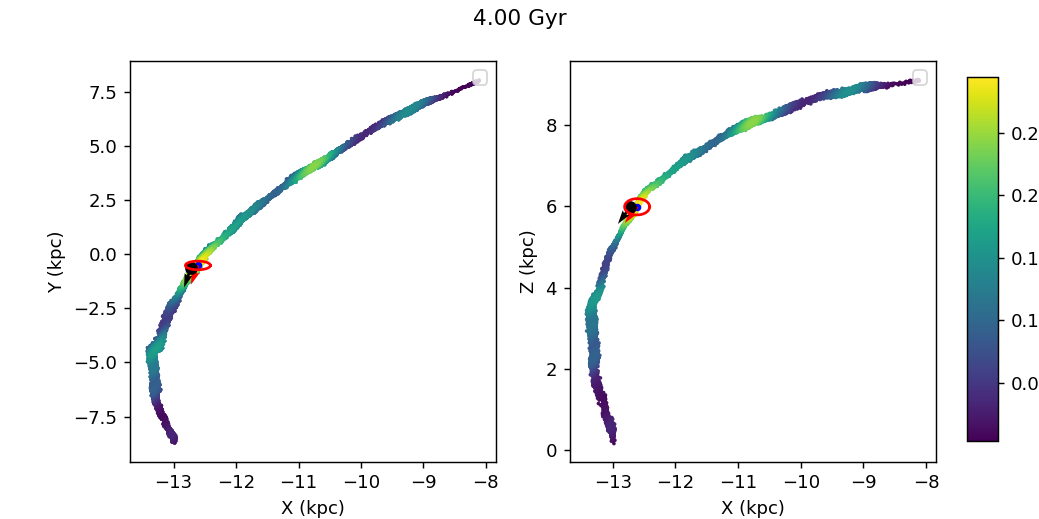

No handles with labels found to put in legend.
No handles with labels found to put in legend.


In [6]:
#since the snapshots are huge, load only the ones needed
sn = 400
kk = sn - 300

dir_flip = "ics/MW_GB_Mres1e4Msun_GD-1_WithDisk_halovel_flippedInitialPosition/"
t,_,x4fl,y4fl,z4fl,vx4fl,vy4fl,vz4fl,_ = extract_data_of_ptype(folder=dir_flip,ptype=4,nfiles=kk+1,shift_file_ind=kk,shift_ID=0,pot_acc=False)

xcore,ycore,densxy,X_xy,Y_xy= compute_surface_density(x4fl[0],y4fl[0],bins=[25,25])

_,zcore,densxz,X_xz,Z_xz= compute_surface_density(x4fl[0],z4fl[0],bins=[25,25])

r=0.2
#condition for choosing all points within r 
cond = np.sqrt((x4fl[0] - xcore)**2 + (y4fl[0] - ycore)**2 + (z4fl[0] - zcore)**2) < r

_x4 = x4fl[0][cond]
_y4 = y4fl[0][cond]
_z4 = z4fl[0][cond]
_vx4 = vx4fl[0][cond]
_vy4 = vy4fl[0][cond]
_vz4 = vz4fl[0][cond]

print (len(_x4))

vx_mean = np.mean(_vx4)
vy_mean = np.mean(_vy4)
vz_mean = np.mean(_vz4)

print (xcore,ycore,zcore)
print (vx_mean,vy_mean,vz_mean)


theta = np.linspace(0,2*np.pi,1000)

f, axes = plt.subplots(nrows = 1, ncols = 2,figsize=(8,4))
f.suptitle("{:.2f} Gyr".format(0.01*sn))

sc = axes[0].scatter(X_xy,Y_xy,c=densxy,s=1)
axes[0].scatter(X_xy,Y_xy,c=densxy,s=1)
axes[0].plot(xcore + r*np.cos(theta),ycore+r*np.sin(theta),color='r')
axes[0].scatter(X_xy[densxy.argmax()],Y_xy[densxy.argmax()],s=10,marker='o',c='b',label=r"")
axes[0].quiver(X_xy[densxy.argmax()],Y_xy[densxy.argmax()],vx_mean,vy_mean,color='r')
axes[0].scatter(gc1.x.value,gc1.y.value,c='k')
axes[0].quiver(gc1.x.value,gc1.y.value,gc1.v_x.value,gc1.v_y.value,color='k')
#axes[0].text(-15,-105,"core = ({:.2f},{:.2f})".format(xcore,ycore))
axes[0].legend(loc="upper right")
axes[0].set_xlabel('X (kpc)')
axes[0].set_ylabel('Y (kpc)')

axes[1].plot(xcore + r*np.cos(theta),zcore+r*np.sin(theta),color='r')
axes[1].scatter(X_xz,Z_xz,c=densxz,s=1)
axes[1].scatter(X_xz[densxz.argmax()],Z_xz[densxz.argmax()],s=10,marker='o',c='b',label=r"")
axes[1].quiver(X_xz[densxz.argmax()],Z_xz[densxz.argmax()],vx_mean,vz_mean,color='r')
axes[1].quiver(gc1.x.value,gc1.z.value, gc1.v_x.value, gc1.v_z.value,color='k')
axes[1].scatter(gc1.x.value,gc1.z.value,c='k')
#axes[1].text(-15,-105,"core = ({:.2f},{:.2f})".format(xcore_star_cdm,zcore_star_cdm))
axes[1].legend(loc="upper right")
axes[1].set_xlabel('X (kpc)')
axes[1].set_ylabel('Z (kpc)')
cbar_ax = f.add_axes([0.93, 0.15, 0.03, 0.7])

f.colorbar(sc,cax=cbar_ax)
#plt.tight_layout()
#plt.savefig('Mres1e4_WithDisk_scratch_400.pdf', bbox_inches = "tight")
plt.show()

## Pickle potential

In [ ]:
from galpy.potential import InterpSnapshotRZPotential
import pickle
from galpy.util import bovy_conversion, bovy_plot, save_pickles

ff = Gizmo_to_pynbody(fn="ics/MW_GB_Mres1e5Msun_GD-1_halovel_flippedInitialPosition.hdf5",ptypes=[1])
from galpy.util.bovy_conversion import _G
g= pynbody.array.SimArray(_G/1000.)
g.units= 'kpc Msol**-1 km**2 s**-2 G**-1'
ff._arrays['mass']= ff._arrays['mass']*g

spi= InterpSnapshotRZPotential(ff,rgrid=(np.log(0.01),np.log(100.),101),logR=True,zgrid=(0.,50,101),interpPot=True,\
                               zsym=True,numcores=6)
delattr(spi,'_s')
delattr(spi,'_origPot')

save_pickles("Potential_MWHalo_Mres1e5.pkl",spi)


In [ ]:
from galpy.potential import vcirc

with open("test.pkl",'rb') as savefile:
    newspi= pickle.load(savefile,encoding='latin1')

print (vcirc(newspi, 10),vcirc(spi,10))


In [ ]:
v_sun = coord.CartesianDifferential([11.1, 244, 7.25]*u.km/u.s)

gc2=coord.Galactocentric(x=np.mean(x)*u.kpc,y=np.mean(y)*u.kpc,z=np.mean(z)*u.kpc,v_x=np.mean(vx)*(u.km/u.s),\
                         v_y=np.mean(vy)*(u.km/u.s),v_z=np.mean(vz)*(u.km/u.s),galcen_distance=8.*u.kpc,
                                galcen_v_sun=v_sun,
                                z_sun=0*u.pc)
    
icrs_c2=gc2.transform_to(coord.ICRS)

orbs = Orbit(np.c_[icrs_c2.ra.value,icrs_c2.dec.value,icrs_c2.distance.value,icrs_c2.pm_ra_cosdec.value,\
             icrs_c2.pm_dec.value,icrs_c2.radial_velocity.value],radec=True)

Plot surface density and identify the core, and get its coordinates and velocity

## Test analytic disk in Gizmo vs Galpy

In [ ]:
dir1 = "ics/single_particle/"

mm = 101
tt4,id4,x4,y4,z4,vx4,vy4,vz4,m4,pot4,ax4,ay4,az4 = extract_data_of_ptype(folder=dir1,ptype=4,nfiles=mm,shift_file_ind=0,shift_ID=0,pot_acc=True)

In [ ]:
print (x4[0],y4[0],z4[0][0])
print (ax4[0],ay4[0],az4[0])

print (np.sqrt(x4[0][0]**2 + y4[0][0]**2))

In [ ]:
print (x4[0],y4[0],z4[0][0])
print (ax4[0],ay4[0],az4[0])

print (np.sqrt(x4[0][0]**2 + y4[0][0]**2))

In [ ]:
disk_pot = MiyamotoNagaiPotential(amp=5.78*10**10*u.Msun,a=3.*u.kpc,b=0.28*u.kpc)
disk_pot.turn_physical_off()

from galpy.potential import evaluateRforces,evaluatezforces
_r = np.sqrt(x4[0][0]**2 + y4[0][0]**2)

galpy_aR = evaluateRforces(disk_pot,R=_r/8,z=z4[0][0]/8)*bovy_conversion.force_in_kmsMyr(220.,8.)
galpy_az = evaluatezforces(disk_pot,R=_r/8,z=z4[0][0]/8)*bovy_conversion.force_in_kmsMyr(220.,8.)

gizmo_aR = np.sqrt(ax4[0][0]**2 + ay4[0][0]**2)*0.001*(1.023) #km/s = 1.023 kpc/Gyr
gizmo_az = az4[0][0]*0.001*(1.023)

print ((galpy_aR/gizmo_aR))

print ((galpy_az/gizmo_az))


In [ ]:
dir_flip = "ics/MW_GB_Mres1e4Msun_GD-1_WithDisk_halovel_flippedInitialPosition/"#dir_ini = "ics/MW_GB_Mres1e6Msun_GD-1_InitialPosition/"
dir_flip = "ics/MW_GB_Mres1e6Msun_GD-1_halovel_flippedInitialPosition/"

rc = [];

tt=[];

for ii in range(410):
       
    t,_,x4fl,y4fl,z4fl,_,_,_,_ = extract_data_of_ptype(folder=dir_flip,ptype=4,nfiles=ii+1,shift_file_ind=ii,shift_ID=0,pot_acc=False)
    xcore,ycore,_,_,_= compute_surface_density(x4fl[0],y4fl[0])
    _,zcore,_,_,_= compute_surface_density(x4fl[0],z4fl[0])
    r = np.sqrt(xcore**2 + ycore**2 + zcore**2)
    rc.append(r)
    tt.append(t)
    

In [ ]:
tt = []
rc=[]

for ii in range(41):
    t,r,vx,vy,vz = np.loadtxt("Mres1e5_t-r_v_{}.dat".format(ii),unpack=True)
    for _t in t:
        tt.append(_t)
    for _r in r:
        rc.append(_r)

In [ ]:
#fo=open("t-r.dat","w")
#for ii in range(len(tt)):
#    fo.write(str(tt[ii][0]) + "  " + str(rc[ii]) + "\n")
#fo.close()

plt.figure()
plt.plot(tt,rc)
plt.ylabel("r (kpc)")
plt.xlabel("t (Gyr)")
plt.savefig("Mres1e5_r_GC.pdf")
plt.show()

compute eccentricity 

In [ ]:
#first get the halo and convert to galpy potential
import pynbody


In [ ]:
delattr(spi,'_s')


Convert to ra,dec

In [ ]:
v_sun = coord.CartesianDifferential([11.1, 244, 7.25]*u.km/u.s)

gc2=coord.Galactocentric(x=_x4*u.kpc,y=_y4*u.kpc,z=_z4*u.kpc,v_x=_vx4*(u.km/u.s),\
                         v_y=_vy4*(u.km/u.s),v_z=_vz4*(u.km/u.s),galcen_distance=8.*u.kpc,
                                galcen_v_sun=v_sun,
                                z_sun=0*u.pc)
    
icrs_c2=gc2.transform_to(coord.ICRS)

orbs = Orbit(np.c_[icrs_c2.ra.value,icrs_c2.dec.value,icrs_c2.distance.value,icrs_c2.pm_ra_cosdec.value,\
             icrs_c2.pm_dec.value,icrs_c2.radial_velocity.value],radec=True)

In [ ]:
orbs = Orbit(np.c_[icrs_c2.ra.value,icrs_c2.dec.value,icrs_c2.distance.value,icrs_c2.pm_ra_cosdec.value,\
             icrs_c2.pm_dec.value,icrs_c2.radial_velocity.value],radec=True)

ts = np.linspace(0.,10.,1001)

orbs.integrate(ts,spi)

print (np.mean(orbs.e()))
             

In [ ]:
fig = plt.figure(figsize=(6,6))
#fig, (ax, ax1) = plt.subplots(1, 2)
ax = fig.add_subplot(111)
title = ax.set_title(r'$t$')
sct, = ax.plot([], [], "o", markersize=1,c='green')
#sct1, = ax.plot([], [], "o", markersize=0.5,c='r')
#sct2, = ax.plot([], [], "o", markersize=0.5,c='blue')
#sct3, = ax.plot([], [], "o", markersize=0.2,c='orange')
ax.set_xlabel("X (kpc)")
ax.set_ylabel("Z (kpc)")
#ax1.set_xlabel("X (kpc)")
#ax1.set_ylabel("Z (kpc)")


def update(ifrm,xa,za,tim):
    
    sct.set_data(xa[ifrm], za[ifrm])
    #sct1.set_data(xs[ifrm], zs[ifrm])
    #sct2.set_data(xb[ifrm], zb[ifrm])
    #sct3.set_data(xc[ifrm], zc[ifrm])
      
    title.set_text(r'$t = %.2f$ Gyr'%(tim[ifrm]+3))
  

#print (xall[0:30])
#print (vxall[500:530])
ax.set_xlim(-50,50)
ax.set_ylim(-50,50)

ani = animation.FuncAnimation(fig, update, mn, fargs=(x4,z4,tt4), interval=10,repeat_delay=1000.)
#ani = animation.FuncAnimation(fig, update, nfr-shift, fargs=(si_x,si_z,x,z,a_x,a_z,tt), interval=50/fps,repeat_delay=2000.)

fn = 'MW_GD1_analytic_disk'
#fn = "SIDM_Yukawa_sigma0_500000_V0_3_CircOrbit_xyprojection"
ani.save(fn+'.mp4',writer='ffmpeg',fps=50)

In [ ]:
dir2 = "ics/MW_GB_Mres1e5Msun_GD-1_halovel_flippedInitialPosition/"

tt4,id4,x4,y4,z4,vx4,vy4,vz4,m4 = extract_data_of_ptype(folder=dir2,ptype=4,nfiles=401,shift_file_ind=400,shift_ID=0,pot_acc=False)

x4 = x4[0]
y4 = y4[0]
z4 = z4[0]
vx4 = vx4[0]
vy4 = vy4[0]
vz4 = vz4[0]

## Align stream along $\phi_{1}$ and $\phi_{2}$
Compute angular momentum after shifting origin to the Sun and rotate the sky such that the angular momentum points along +z axis 

In [103]:
def align_stream(fn,output_galcoords=False):
    
    from galpy.util import _rotate_to_arbitrary_vector
    x,y,z = read_snapshot(fn,ptype=4)
    vx,vy,vz = read_snapshot(fn,ptype=4,read_axes="Velocities")
    
    #transform Galactocentric coordinates (box frame) to Galactic coordinates
    v_sun = coord.CartesianDifferential([11.1, 244, 7.25]*u.km/u.s)

    gc2=coord.Galactocentric(x=x*u.kpc,y=y*u.kpc,z=z*u.kpc,v_x=vx*(u.km/u.s),\
                         v_y=vy*(u.km/u.s),v_z=vz*(u.km/u.s),galcen_distance=8.*u.kpc,
                                galcen_v_sun=v_sun,
                                z_sun=0*u.pc)

    gal_c2=gc2.transform_to(coord.ICRS)
    gal_c2.representation_type = 'cartesian'

    #compute angluar momentum
    L = []

    for ii in range(len(x)):
        r = [gal_c2.x.value[ii],gal_c2.y.value[ii],gal_c2.z.value[ii]]
        v = [gal_c2.v_x.value[ii],gal_c2.v_y.value[ii],gal_c2.v_z.value[ii]]
        #print (r,v)
        L.append(np.cross(r,v))

    L = np.array(L)
    
    mean_L = np.mean(L,axis=0)
    
    #normalize
    mean_l = np.mean(L,axis=0)/np.linalg.norm(np.mean(L,axis=0))
    #print (mean_l)

    rot_mat = _rotate_to_arbitrary_vector(np.atleast_2d(mean_l),np.array([0,0,1]),inv=False,_dontcutsmall=False)
    #print (rot_mat)

    print (np.dot(rot_mat,mean_l))
    r_rot = []
    v_rot = []

    for ii in range(len(x)):
        r = [gal_c2.x.value[ii],gal_c2.y.value[ii],gal_c2.z.value[ii]]
        v = [gal_c2.v_x.value[ii],gal_c2.v_y.value[ii],gal_c2.v_z.value[ii]]
        r_rot.append(np.dot(rot_mat,r)[0])
        v_rot.append(np.dot(rot_mat,v)[0])

    r_rot = np.array(r_rot)
    v_rot = np.array(v_rot)
    
    if output_galcoords :
        return (gal_c2,mean_L,r_rot[:,0],r_rot[:,1],r_rot[:,2],v_rot[:,0],v_rot[:,1],v_rot[:,2])
    else :
        return (r_rot[:,0],r_rot[:,1],r_rot[:,2],v_rot[:,0],v_rot[:,1],v_rot[:,2])
        




In [104]:
dir_flip = "ics/MW_GB_Mres1e4Msun_GD-1_WithDisk_halovel_flippedInitialPosition/"
fn = dir_flip + "snapshot_100.hdf5" #100 since we start outputs from 300

galc2,Lmean,x,y,z,vx,vy,vz = align_stream(fn,output_galcoords=True)

[[ 2.77555756e-17 -5.55111512e-17  1.00000000e+00]]


In [121]:
xcore,ycore,densxy,_x,_y= compute_surface_density(galc2.x.value,galc2.y.value,method="Gaussian",bw=None,bins=[20,20])
xcore1,zcore,densxz,_x1,_z= compute_surface_density(galc2.x.value,galc2.z.value,method="Gaussian",bw=None,bins=[20,20])

<IPython.core.display.Javascript object>


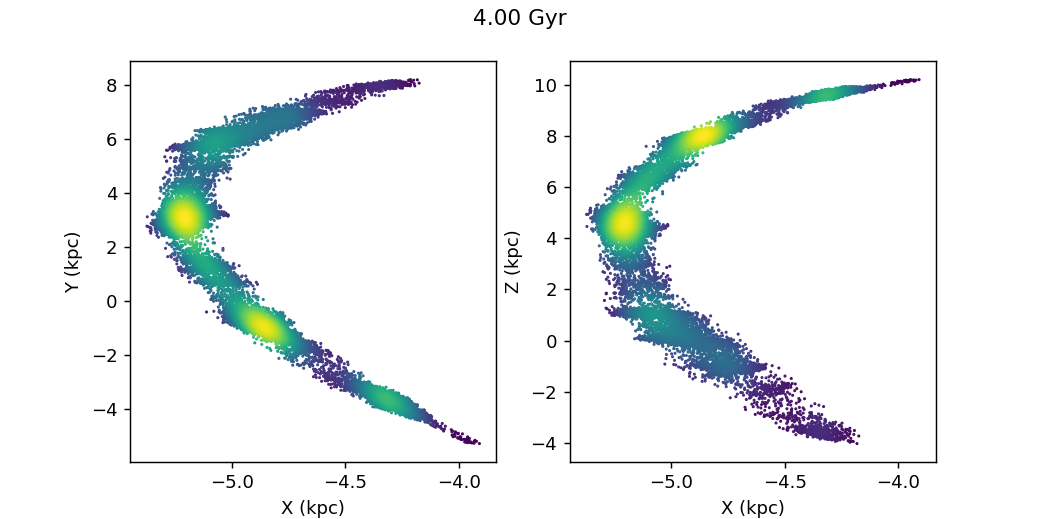

In [122]:
plt.figure(figsize=(8,4))
plt.suptitle("{:.2f} Gyr".format(0.01*400))
plt.subplot(1,2,1)
#plt.scatter(galc2.x.value,galc2.y.value,s=0.5,c=densxy)
plt.scatter(_x,_y,s=0.5,c=densxy)
#plt.quiver(xcore,ycore,Lmean[0],Lmean[1])
plt.xlabel("X (kpc)")
plt.ylabel("Y (kpc)")
#plt.xlim(-6,6)
#plt.ylim(-6,6)

plt.subplot(1,2,2)
#plt.scatter(galc2.x.value,galc2.z.value,s=0.5,c=densxz)
plt.scatter(_x1,_z,s=0.5,c=densxz)
#plt.quiver(xcore,zcore,Lmean[0],Lmean[2])
plt.xlabel("X (kpc)")
plt.ylabel("Z (kpc)")
#plt.xlim(-6,6)
#plt.ylim(-36,6)
plt.show()
    
    

In [124]:
xcore,ycore,densxy,_x,_y= compute_surface_density(x,y,method="Gaussian",bw=0.01,bins=[20,20])
xcore1,zcore,densxz,_x1,_z= compute_surface_density(x,z,method="Gaussian",bw=0.01,bins=[20,20])
ycore1,zcore1,densxz,_y1,_z1= compute_surface_density(y,z,method="Gaussian",bw=0.01,bins=[20,20])

In [125]:
def find_centre_of_density(
    x,y,z,vx,vy,vz,m,
    xstart=0.0,
    ystart=0.0,
    zstart=0.0,
    vxstart=0.0,
    vystart=0.0,
    vzstart=0.0,
    indx=None,
    rmin=0.1,
    nmax=100,
):
    """Find cluster's centre of density

    - The motivation behind this piece of code comes from phigrape (Harfst, S., Gualandris, A., Merritt, D., et al. 2007, NewA, 12, 357) courtesy of Yohai Meiron
    - The routine first finds the centre of density of the whole system, and then works to identify a sphere stars around the centre in which to perform the final centre of density calculation. Stars with radii outside 80% of the maximum radius are removed from the calculation until the final subset of stars are enclosed within a radius rmin. The maximum size of the final subset is nmax. This step prevents long tidal tails from affecting the calculation

    Parameters
    ----------
    cluster : class
        StarCluster
    xstart,ystart,zstart : float
        starting position for centre (default: 0,0,0)
    vxstart,vystart,vzstart : float
        starting velocity for centre (default: 0,0,0)
    indx: bool
        subset of stars to perform centre of density calculation on (default: None)
    rmin : float
        minimum radius of sphere around which to estimate density centre (default: 0.1 cluster.units)
    nmax : float
        maximum number of iterations (default:100)

    Returns
    -------
    xc,yc,zc,vxc,vyc,vzc : float
        coordinates of centre of mass

    HISTORY
    -------
    2019 - Written - Webb (UofT) with Yohai Meiron (UofT)
    """
    if indx is None:
        #indx = np.ones(cluster.ntot, bool)
        indx = np.ones(len(x), bool)

    #m = cluster.m[indx]
    x = x - xstart
    y = y - ystart
    z = z - zstart
    vx = vx - vxstart
    vy = vy - vystart
    vz = vz - vzstart

    r = np.sqrt(x ** 2.0 + y ** 2.0 + z ** 2.0)
    rlim = np.amax(r)

    xdc, ydc, zdc = xstart, ystart, zstart
    vxdc, vydc, vzdc = vxstart, vystart, vzstart

    n = 0

    while (rlim > rmin) and (n < nmax):
        r2 = x ** 2.0 + y ** 2.0 + z ** 2.0
        indx = r2 < rlim ** 2
        nc = np.sum(indx)
        mc = np.sum(m[indx])

        if mc == 0:
            xc, yc, zc = 0.0, 0.0, 0.0
            vxc, vyc, vzc = 0.0, 0.0, 0.0
        else:

            xc = np.sum(m[indx] * x[indx]) / mc
            yc = np.sum(m[indx] * y[indx]) / mc
            zc = np.sum(m[indx] * z[indx]) / mc

            vxc = np.sum(m[indx] * vx[indx]) / mc
            vyc = np.sum(m[indx] * vy[indx]) / mc
            vzc = np.sum(m[indx] * vz[indx]) / mc

        if (mc > 0) and (nc > 100):
            x -= xc
            y -= yc
            z -= zc
            xdc += xc
            ydc += yc
            zdc += zc

            vx -= vxc
            vy -= vyc
            vz -= vzc
            vxdc += vxc
            vydc += vyc
            vzdc += vzc

        else:
            break
        rlim *= 0.8
        n += 1

    return xdc, ydc, zdc,vxdc, vydc, vzdc


In [126]:
xc,yc,zc,_,_,_ =  find_centre_of_density(x,y,z,vx,vy,vz,0.46*np.ones(len(z)))

In [131]:
#compute angluar momentum
L_rot = []

for ii in range(len(x)):
    L_rot.append(np.cross([x[ii],y[ii],z[ii]],[vx[ii],vy[ii],vz[ii]]))

L_rot = np.array(L_rot)
Lmean = np.mean(L_rot,axis=0)

phi1 = np.degrees(np.arctan2(y,x))
phi2 = np.degrees(np.arctan2(np.sqrt(x**2 + y**2),z))

p1core,p2core,densp12,p1,p2= compute_surface_density(phi1,phi2,method="Gaussian",bw=0.01,bins=[20,20])

#bin in phi1 and compute velocity dispersion and density
phi1_bins = np.linspace(phi1.min(),phi1.max(),61)
phi1_mid = [0.5*(phi1_bins[ii]+phi1_bins[ii+1]) for ii in range(len(phi1_bins)-1)]
p1_binned = np.histogram(phi1,bins = phi1_bins)[0]

v_disp =[]
for ii in range(len(phi1_bins)-1):
    _vx = vx[(phi1 > phi1_bins[ii]) & (phi1 < phi1_bins[ii+1])]
    _vy = vy[(phi1 > phi1_bins[ii]) & (phi1 < phi1_bins[ii+1])]
    _vz = vz[(phi1 > phi1_bins[ii]) & (phi1 < phi1_bins[ii+1])]
    v_disp.append(np.sqrt(np.std(_vx)**2 + np.std(_vy)**2 + np.std(_vz)**2))

print (v_disp)

[1.6911662854367322, 1.8693624997327447, 2.1672078995464243, 2.2369864667951034, 1.952945083810794, 2.3393920015422447, 2.3247393608359452, 2.200036738009289, 1.8842926600908676, 1.9133257129360344, 1.8962657045030473, 2.0329101079732292, 1.7592537990253514, 1.7397875702381111, 1.488916391788903, 1.565523548449269, 1.334795944255037, 1.522535676496704, 1.288731021910046, 1.2367322229812865, 1.2769981045870258, 1.1132135547481148, 1.2325555405223845, 1.3097516152815631, 1.4312571259730709, 1.1353961879576127, 1.3258588088494585, 1.3101017828414683, 1.4076937940613565, 1.2344007682862275, 1.2424184052357972, 1.2480266185413142, 1.22718469473301, 1.1224053181327176, 1.1164412654104061, 1.1898400090245642, 1.2224974895363556, 1.314233047437121, 1.043954932143286, 1.0484000058992966, 1.1186143730902667, 1.2798893138450413, 1.1108105080665605, 0.9934463983506135, 1.1859365027597883, 1.189832008855621, 1.2332656476703021, 1.3142530752533412, 1.156394507025522, 1.3073070882532867, 1.3543211736

<IPython.core.display.Javascript object>


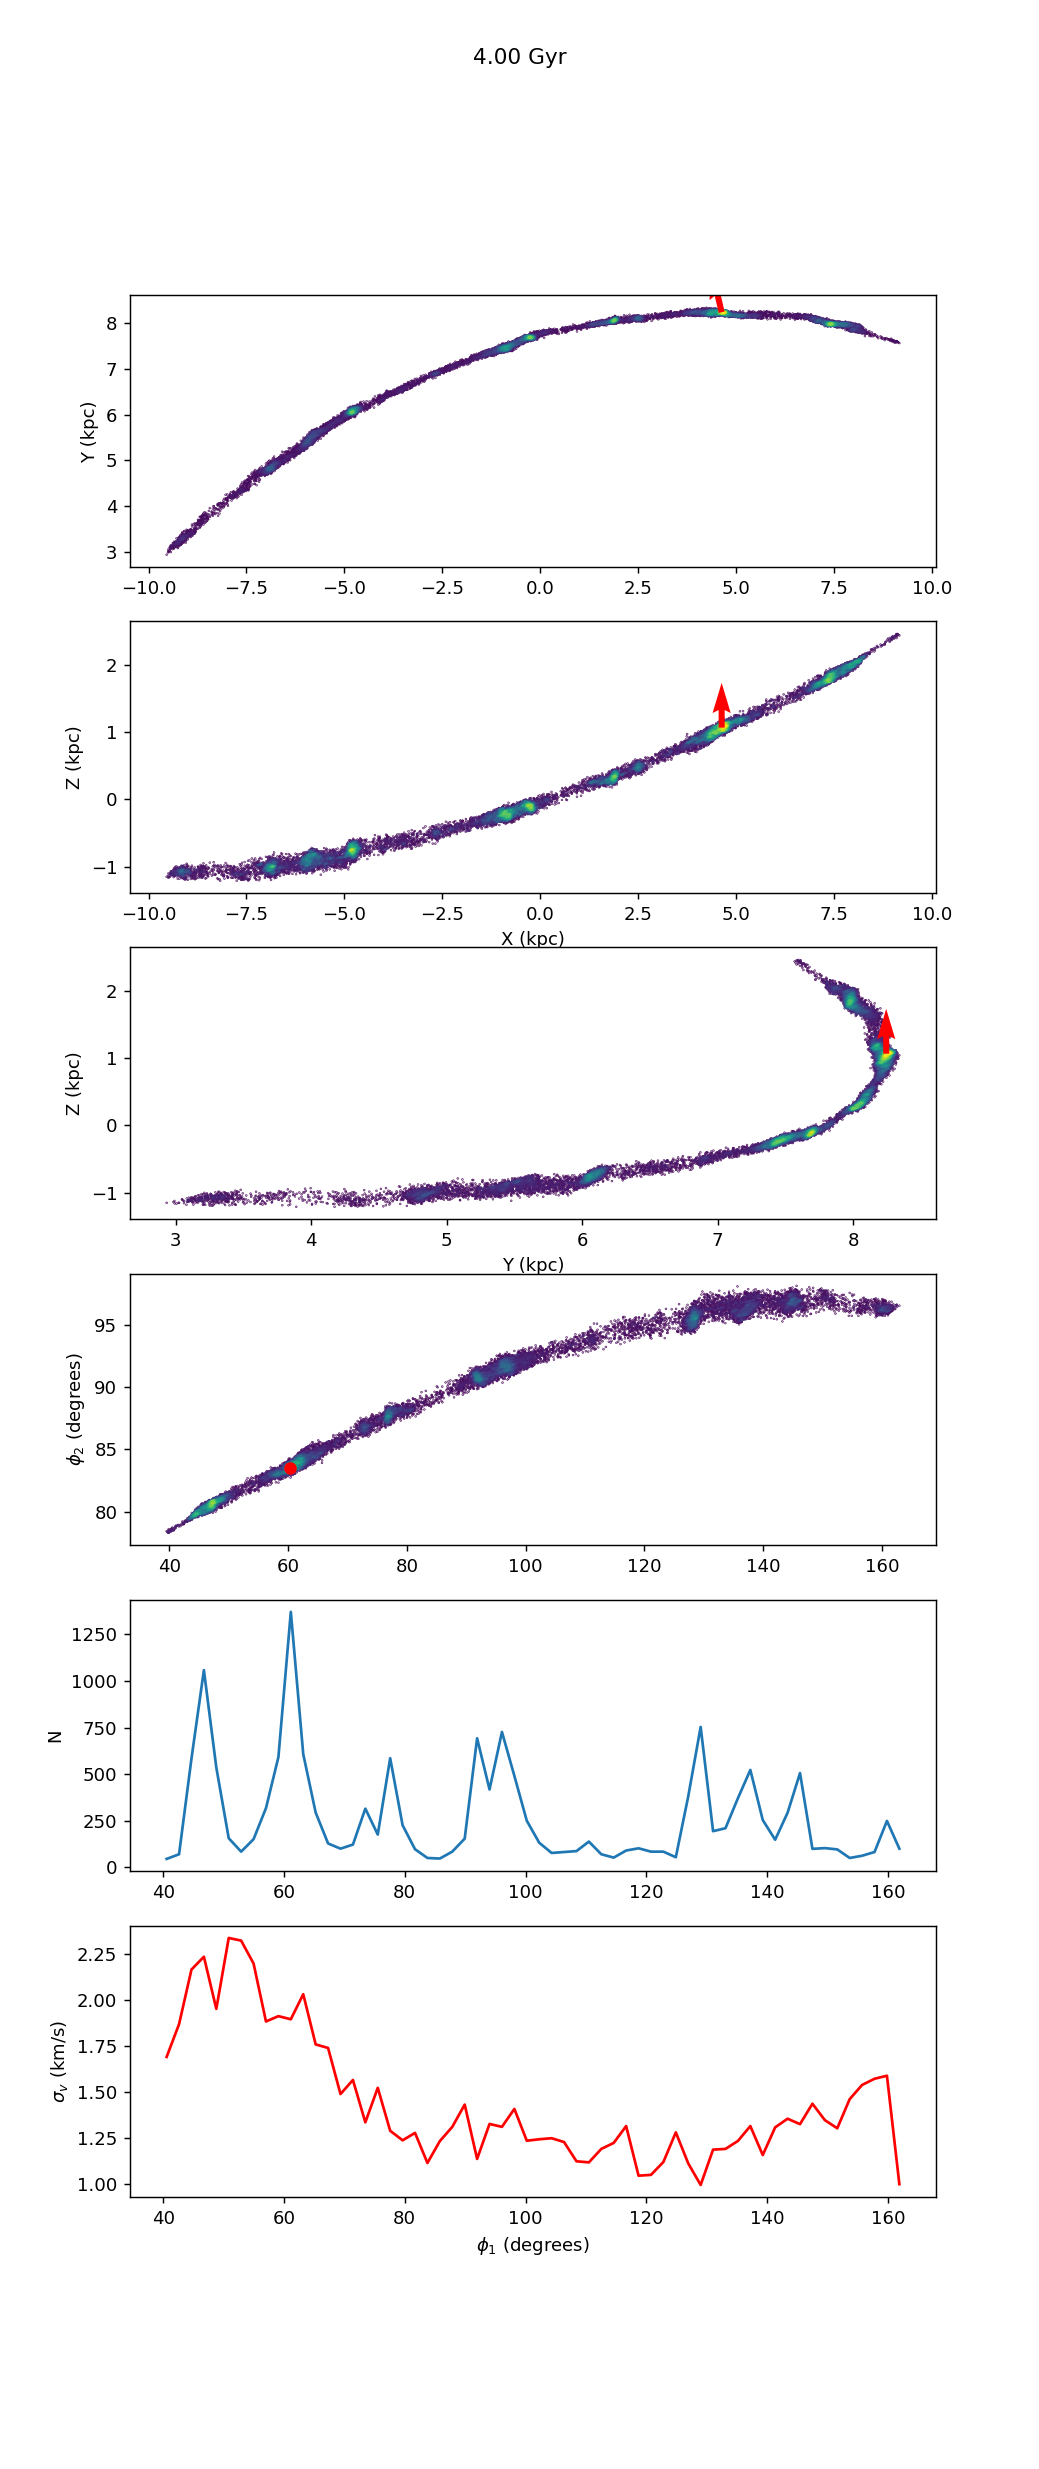

In [142]:
plt.figure(figsize=(8,19))
plt.suptitle("{:.2f} Gyr".format(0.01*400))
plt.subplot(6,1,1)
#plt.scatter(galc2.x.value,galc2.y.value,s=0.5,c=densxy)
plt.scatter(_x,_y,s=0.1,c=densxy)
plt.quiver(xc,yc,Lmean[0],Lmean[1],color="r")
#plt.xlabel("X (kpc)")
plt.ylabel("Y (kpc)")
#plt.xlim(-6,6)
#plt.ylim(-6,6)

plt.subplot(6,1,2)
#plt.scatter(galc2.x.value,galc2.z.value,s=0.5,c=densxz)
plt.scatter(_x1,_z,s=0.1,c=densxz)
plt.quiver(xc,zc,Lmean[0],Lmean[2],color="r")
plt.xlabel("X (kpc)")
plt.ylabel("Z (kpc)")

plt.subplot(6,1,3)
#plt.scatter(galc2.x.value,galc2.z.value,s=0.5,c=densxz)
plt.scatter(_y1,_z1,s=0.1,c=densxz)
plt.quiver(yc,zc,Lmean[1],Lmean[2],color="r")
plt.xlabel("Y (kpc)")
plt.ylabel("Z (kpc)")
#plt.xlim(-6,6)
#plt.ylim(-36,6)

plt.subplot(6,1,4)
plt.scatter(p1,p2,s=0.1,c=densp12)
plt.scatter(p1core,p2core,color="r")
#plt.xlabel(r"$\phi_{1}$ (degrees)")
plt.ylabel(r"$\phi_{2}$ (degrees)")

plt.subplot(6,1,5)
plt.plot(phi1_mid,p1_binned)
#plt.xlabel(r"$\phi_{1}$ (degrees)")
plt.ylabel("N")

plt.subplot(6,1,6)
plt.plot(phi1_mid,v_disp,c='r')
plt.xlabel(r"$\phi_{1}$ (degrees)")
plt.ylabel(r"$\sigma_v$ (km/s)")
plt.show()
    
    

<IPython.core.display.Javascript object>


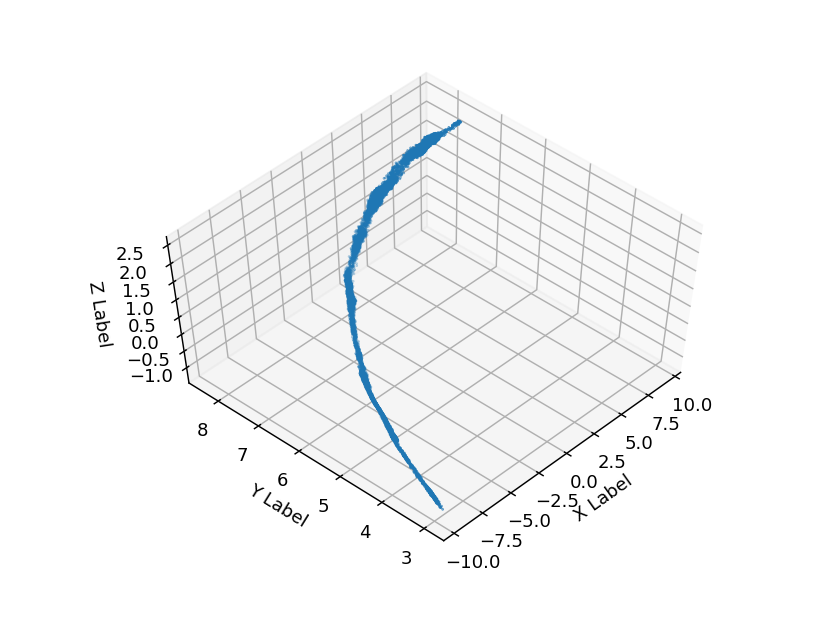

In [111]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z,s=0.2)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

In [ ]:

print (mean_L)
xcore,ycore,_,_,_= compute_surface_density(gal_c2.x.value,gal_c2.y.value)
_,zcore,_,_,_= compute_surface_density(gal_c2.x.value,gal_c2.z.value)


In [ ]:
print (r_rot[0])

In [ ]:
xcore_rot,ycore_rot,_,_,_= compute_surface_density(r_rot[:,0],r_rot[:,1])
_,zcore_rot,_,_,_= compute_surface_density(r_rot[:,0],r_rot[:,2])

In [ ]:
dir1 = "ics/single_particle/"
tt1,id1,x1,y1,z1,vx1,vy1,vz1,m1,pot1,ax1,ay1,az1 = extract_data_of_ptype(folder=dir1,ptype=4,nfiles=83,shift_file_ind=0,shift_ID=0,pot_acc=True)

  

In [ ]:
def MN_acc(x,y,z,M=5.78,a=3.,b=0.28):
    
    G=43007.1
    R = np.sqrt(x**2 +y**2)
    fac1 = np.sqrt(z**2 + b**2)
    fac = (R**2 + (a + fac1)**2)**(-1.5)
    ax = -G*M*x*fac
    ay = -G*M*y*fac
    az = -G*M*z*(1+a/fac1)*fac
    return (ax,ay,az)



In [ ]:
ax_t = []
ay_t = []
az_t = []
for ii in range(len(m1)):
    ax_t.append(MN_acc(x1[ii],y1[ii],z1[ii])[0][0])
    ay_t.append(MN_acc(x1[ii],y1[ii],z1[ii])[1][0])
    az_t.append(MN_acc(x1[ii],y1[ii],z1[ii])[2][0])
               
plt.figure()
plt.plot(tt1,ax1)
plt.plot(tt1,ax_t,ls="--")
plt.show()

In [ ]:
dir1 = "ics/MW_GB_Mres1e6Msun_GD-1_currentPos_velflipped/"
dir2 = "ics/GD-1_currentPos_velflipped/"

_,_,x4,y4,z4,_,_,_,_,_,ax4,ay4,az4 = extract_data_of_ptype(folder=dir1,ptype=4,nfiles=50,shift_file_ind=0,shift_ID=0,pot_acc=True)
_,_,xa,ya,za,_,_,_,_,_,axa,aya,aza = extract_data_of_ptype(folder=dir2,ptype=4,nfiles=50,shift_file_ind=0,shift_ID=0,pot_acc=True)

plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.hist(ax4[3],histtype="step",label='Nbody')
plt.hist(axa[3],histtype="step")
plt.legend(loc="upper right")

plt.subplot(1,3,2)
plt.hist(ay4[3],histtype="step")
plt.hist(aya[3],histtype="step")

plt.subplot(1,3,3)
plt.hist(az4[3],histtype="step")
plt.hist(aza[3],histtype="step")
plt.show()

plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.hist(x4[3],histtype="step")
plt.hist(xa[3],histtype="step")

plt.subplot(1,3,2)
plt.hist(y4[3],histtype="step")
plt.hist(ya[3],histtype="step")

plt.subplot(1,3,3)
plt.hist(z4[3],histtype="step")
plt.hist(za[3],histtype="step")
plt.show()

